# Deutsch-Jozsa Algorithm

Deutsch's algorithm, which was later generalized to the Deutsch-Josza algorithm, was the first quantum algorithm with an exponential speed-up compared to any classical algorithm. I went through the basics of the algorithm in [this post](https://appliedqc.org/2020/02/27/Deutsch-Jozsa-Algorithm.html). Now I want to do an actual, real life comparison between quantum and classical.

#### Prerequisites:
* [Deutsch-Jozsa Algoirthm: 1st Expoential Quantum Speedup](https://appliedqc.org/2020/02/27/Deutsch-Jozsa-Algorithm.html)

In [1]:
import numpy as np
import random
import time

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from qiskit import *

## Review: Deutsch-Jozsa Problem (and algorithm)
The Deutsch-Jozsa problem is specially concocted to give a quantum computer an exponential speedup compared to a classical computer. Let's review the problem and its solution.

The problem goes like this. Given an unknown binary function $f(x)$ (aka black box or oracle) that maps $n$ bit to one bit, $f(x):\{0,1\}^n \rightarrow\{0,1\}$, determine if $f(x)$ is constant or balanced. A constant function means no matter what binary number we input, $f(x)$ will always output the same value. A balanced function means half of the inputs output 0 and the other half output 1.

### Quantum Algorithm
And, if you remember, the algorithm went something like this:
![png](Deutsch-Jozsa_algo.png)
Measuring the $n$ input qubits at the very end will give all 0's <strong>only</strong> for a constant function. If we measure <strong>any other</strong> state, we know $f(x)$ is a balanced function. Thus, we know the answer in (theoretically) one execution of $f(x)$.

### Classical Algorithm
The deterministic way to do this is to input randomly binary numbers until either: (1) the function has output both a 0 and 1 or (2) we've tried $2^{n-1}+1$ numbers. In the case (1), once the function as output a 0 and 1, we immediately know the function is balanced. In case (2), we have tried one more input than half of all possible inputs. If the function has output the same value the whole time, it must be constant. Thus, the worst case scenario takes $2^{n-1}+1$ executions of $f(x)$. However, the best case scenario is a balanced function with $2$ executions.

The best case scenario is exponentially better than the worst case, which got me thinking. How much exponentially faster is the quantum algorithm REALLY? If we randomly choose constant and balanced functions, what's the average speedup of the quantum computer? Is it still exponentially?

## Generate Constant and Balanced Functions
Our first step is to generate constant and balanced functions. The constant ones are easy, there are only two unique outputs! Haha. The balanced functions are trickier because there are lots of ways to do it. I'll pick a relatively easy way; given a binary input x, the output of $f_i(x)$ will be the ith digit of $x$. This will give us $n$ balanced functions to choose from. For $x=001$, then $f_0(x) = 1$, $f_1(x) = 0$, and $f_2(x) = 0$.

In [2]:
# Two possible constant functions
def f_const0(x):
    return 0

def f_const1(x):
    return 1

# ith Balanced function. Returns the ith digital of x. Range is 0 to n-1 
def f_bal0(x, i=0):
    ith_digit = (x // 10**i) % 10
    return ith_digit

def f_bal1(x, i=1):
    ith_digit = (x // 10**i) % 10
    return ith_digit

## Deterministic Classical Algorithm
Now that we have some functions, let's define our classical algorithm. The algorithm will unknowingly ingest either a balanced or constant function $f(x)$ and the number of bits $n$. Let's have it randomly choose binary numbers to run in the functions. If it tries $2^{n-1}+1$ inputs (one more than half the possible binary numbers for the given $n$) and gets the same output from $f(x)$ every time, it'll return a 0 indicating $f(x)$ is a constant function. If $f(x)$ outputs something different than a previous execution, we know it can't be a constant function. We'll immediately break and return a 1 indicating $f(x)$ is a balanced function. Of course, we'll include some approximate time keeping in the classical algorithm, so we can compare it to the quantum algorithm.

In [88]:
# Helper function to convert between base 10 and base 2 (binary) numbers
def dec_to_binary(x):
    if x < 1:
        return 0
    binary_length = int(np.log2(x)) + 1  # calculat number of binary digits
    binary = ['0']*binary_length  # will binary digits with '0'
    while x > 0:
        n = int(np.log2(x))
        binary[binary_length - 1 - n] = '1'
        x = x - 2**n
    return int("".join(binary))


# Input function and number of bits. Returns 0 if f is constant and 1 if f is balanced
def classical_algo(f, n):
    # Generate inputs
    random_inputs = random.sample(range(2**n), 2**(n-1)+1)  # 2^(n-1) + 1 unique random samples from 0 to 2^n - 1
    # Convert randomly generated inputs into binary
    binary_inputs = []
    for x in random_inputs:
        binary_inputs.append(dec_to_binary(x))
    # Determine if f is balanced or constant
    outputs = []  # initialize list to later store outputs
    start_time = time.time()  # start timing
    for i, x in enumerate(binary_inputs):  # iterate through random inputs
        outputs.append(f(x))  # keep track of f(x) outputs
        if i > 1:
            if outputs[i-1] != outputs[i]:  # if outputs is different from previous f(x), f must be balanced
                end_time = time.time()
                return 1, (end_time - start_time)  # BALANCED FUNCTION
    # if we get this far, 50% + 1 of the possible inputs gave the same output. Therefore, f must be constant.
    end_time = time.time()
    return 0, (end_time - start_time)  # CONSTANT FUNCTION


## Time it: Balanced Functions

In [4]:
# This will run for 10s of minutes

reps = 200  # number of repeated timings so we can get some statistics
ns_bal = np.arange(2, 17)
f_bals = [f_bal0, f_bal1]
f_consts = [f_const0, f_const1]

# Initialize arrays that will store results
bal_time = np.zeros(len(ns_bal) * reps)
labels = np.zeros(len(ns_bal) * reps)

for j in range(reps):
    for i, n in enumerate(ns_bal):
        index = i + j*len(ns_bal)
        labels[index], bal_time[index] = classical_algo(f_bals[0], n)

In [5]:
# Compute means from runs
bal_time = bal_time.reshape(reps, len(ns_bal))
bal_time_means = np.mean(bal_time, axis=0)
bal_time_means

array([3.55720520e-06, 2.31027603e-06, 2.51293182e-06, 2.46644020e-06,
       2.44140625e-06, 2.34484673e-06, 2.66313553e-06, 3.11732292e-06,
       3.51548195e-06, 4.07934189e-06, 4.41789627e-06, 4.82678413e-06,
       6.06656075e-06, 6.55293465e-06, 6.96420670e-06])

In [6]:
# Compute standard deviations from runs
bal_time_stds = np.std(bal_time, axis=0)
bal_time_stds

array([1.21835393e-06, 7.65687494e-07, 8.42883021e-07, 1.46109891e-06,
       1.88022037e-06, 1.05006469e-06, 1.61722856e-06, 2.76215281e-06,
       1.98131398e-06, 3.02319929e-06, 2.73339492e-06, 2.21363626e-06,
       2.89594649e-06, 1.39265382e-06, 1.91665258e-06])

Average label should be exactly 1: 0.9763333333333334


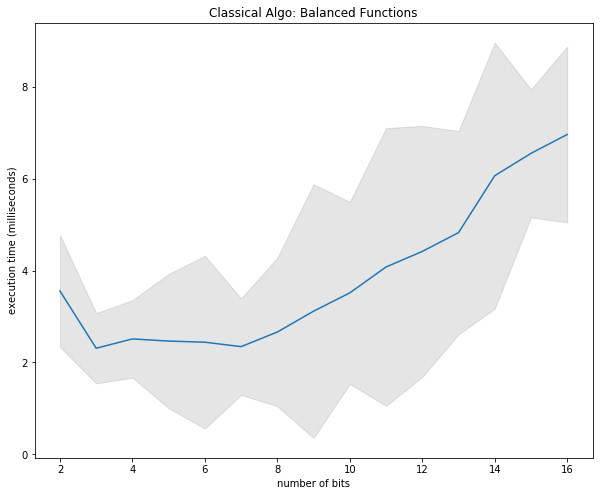

In [7]:
# Check it labeled the function correctly
print("Average label should be exactly 1:", np.mean(labels))

millisec = 10**3
microsec = 10**6

# Plot time it took
plt.figure(figsize=(10,8))
plt.plot(ns_bal, bal_time_means * microsec)
plt.fill_between(ns_bal, (bal_time_means-bal_time_stds)*microsec, 
                 (bal_time_means+bal_time_stds)*microsec, alpha=0.1, color='k')

plt.title('Classical Algo: Balanced Functions')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

Fit parameters: [1.80136277e-07 3.23594042e-01 2.18712181e-06]


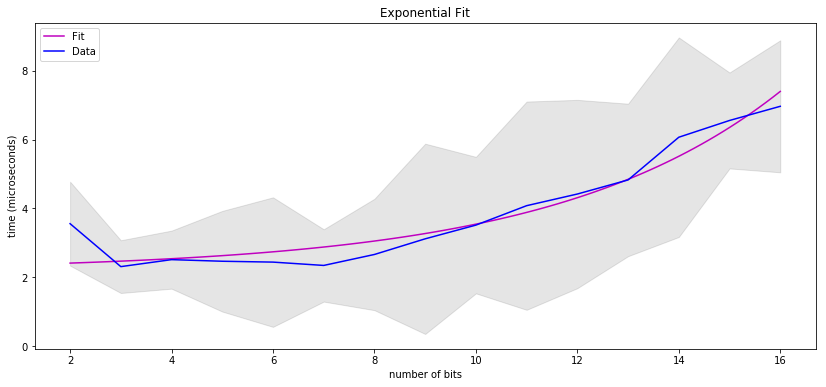

In [19]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

popt, pcov = curve_fit(exp, ns_bal, bal_time_means)

print("Fit parameters:", popt)
xs = np.linspace(ns_bal[0], ns_bal[-1], 100)
ys = exp(xs, *popt)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys * microsec, '-m')
plt.plot(ns_bal, bal_time_means * microsec, '-b')
plt.fill_between(ns_bal, (bal_time_means-bal_time_stds)*microsec, 
                 (bal_time_means+bal_time_stds)*microsec, alpha=0.1, color='k')

plt.title('Exponential Fit')
plt.xlabel('number of bits')
plt.ylabel('time (microseconds)')
plt.legend(['Fit','Data'], loc='upper left')
plt.show()

## Time it: Constant Functions

In [24]:
# This will run for 10s of minutes

reps = 200  # number of repeated timings so we can get some statistics
ns_con = np.arange(2, 16)  # number of bits to consider in algo

# Initialize arrays that will store results
const_time = np.zeros(len(ns_con) * reps)
labels = np.zeros(len(ns_con) * reps)

for j in range(reps):
    for i, n in enumerate(ns_con):
        index = i + j*len(ns_con)
        labels[index], const_time[index] = classical_algo(f_consts[0], n)

In [25]:
# Compute mean and standard deviation from runs
const_time = const_time.reshape(reps, len(ns_con))
const_time_means = np.mean(const_time, axis=0)
const_time_stds = np.std(const_time, axis=0)

Average label should be exactly 0: 0.0


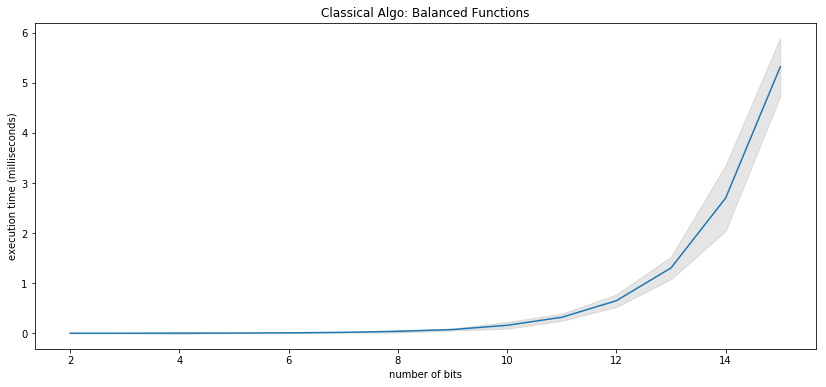

In [26]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", np.mean(labels))

# Plot time it took to run algo
plt.figure(figsize=(14,6))
plt.plot(ns_con, const_time_means * millisec)
plt.fill_between(ns_con, (const_time_means-const_time_stds)*millisec, 
                 (const_time_means+const_time_stds)*millisec, alpha=0.1, color='k')

plt.title('Classical Algo: Balanced Functions')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

Fit parameters: [ 3.24364336e-07  1.00031961e+00 -2.90379370e-06]


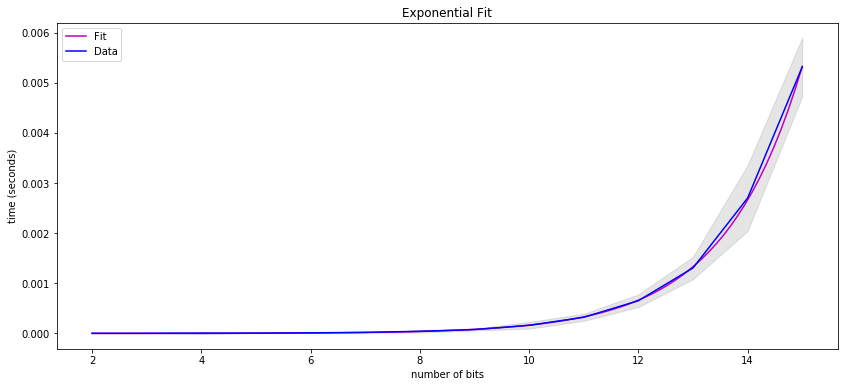

In [28]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

popt, pcov = curve_fit(exp, ns_con, const_time_means)

print("Fit parameters:", popt)
xs = np.linspace(ns_con[0], ns_con[-1], 100)
ys = exp(xs, *popt)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys * millisec, '-m')
plt.plot(ns_con, const_time_means * millisec, '-b')
plt.fill_between(ns_con, (const_time_means-const_time_stds) * millisec, 
                 (const_time_means+const_time_stds) * millisec, alpha=0.1, color='k')

plt.title('Exponential Fit')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Fit','Data'], loc='upper left')
plt.show()

## Generate Constant and Balanced Circuits
Classical is done. Now it's Quantum's turn. We need some constant and balanced $U_f$ operations to run in the Deutsch-Jozsa algorithm! Again, the two easiest constant functions are do nothing and hence always output 0, or have an $X$ gate and hence always output 1.

Again, the balanced functions are trickier because there are lots of ways to do it. To implement the classical balanced function as a quantum operation, we can apply a control-not (CNOT) gate between the $i$th qubit and the output. This will effectively output the $i$th digit of $x$—just like the classical balanced function.

In [184]:
# Two possible constant U_f operations
def uf_const0(circuit, output_qubit):
    circuit.iden(output_qubit)

def uf_const1(circuit, output_qubit):
    circuit.x(output_qubit)

# ith Balanced function. Returns the ith digital of x. Range is 0 to n-1 
def uf_bal0(circuit, output_qubit, i=0):
    circuit.cx(i, output_qubit)

def uf_bal1(circuit, output_qubit, i=1):
    circuit.cx(i, output_qubit)

## Deterministic Quantum Algorithm: Deutsch-Jozsa

In [185]:
# uf is the U_f you wish to know whether it is balanced or constant and n is the number of INPUT (not total) qubits
def dj_algo_circuit(uf, n):
    circuit = QuantumCircuit(n+1, n)
    circuit.x(n)
    circuit.h(range(n+1))
    circuit.barrier()
    uf(circuit, n)
    circuit.barrier()
    circuit.h(range(n+1))
    circuit.measure(range(n), range(n))
    return circuit

def quantum_algo(uf, n, backend, shots):   
    circuit = dj_algo_circuit(uf, n)
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts, result.time_taken

### Timed: Deutch-Jozsa Simulated Quantum Computer

In [200]:
reps = 100
qs_con = np.arange(2, 13)
backend_sim = BasicAer.get_backend('qasm_simulator')
shots_sim = 1

# Initialize arrays that will store results
qconst_time = np.zeros(len(qs_con) * reps)
qconst_counts = {}

# Execute quantum circuit and view results
for j in range(reps):
    for i, n in enumerate(qs_con):
        index = i + j*len(qs_con)
        qconst_counts[index], qconst_time[index] = quantum_algo(uf_const0, int(n), backend_sim, shots_sim)


## Post Processing

In [201]:
# Compute mean and standard deviation from runs
qconst_time = qconst_time.reshape(reps, len(qs_con))
qconst_time_means = np.mean(qconst_time, axis=0)
qconst_time_stds = np.std(qconst_time, axis=0)

# Add up number of 0 states from the repeated experiments
label_ave = 0
for key1, val1 in qconst_counts.items():
    for key2, val2 in val1.items():
        if 0==int(key2):
            label_ave += 1
zero_state_ave = 1 - label_ave / len(qconst_counts)

Average label should be exactly 0: 0.0


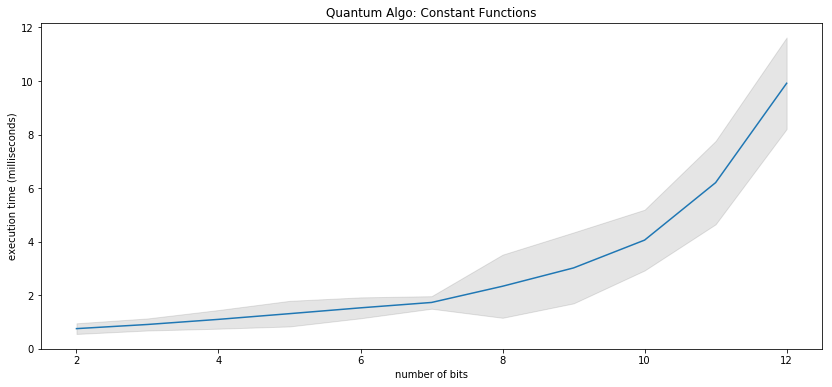

In [202]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", zero_state_ave)

# Plot time it took to run algo
plt.figure(figsize=(14,6))
plt.plot(qs_con, qconst_time_means * millisec)
plt.fill_between(qs_con, (qconst_time_means-qconst_time_stds) * millisec, 
                 (qconst_time_means+qconst_time_stds) * millisec, alpha=0.1, color='k')

plt.title('Quantum Algo: Constant Functions')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

Fit parameters: [3.86774573e-05 7.13158389e-01 9.26564935e-04]


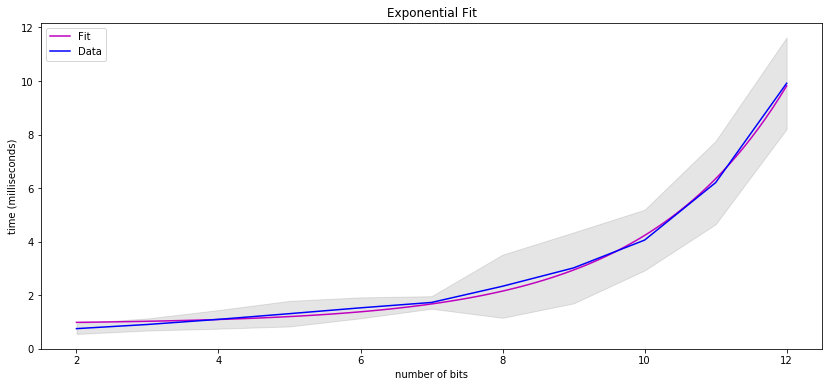

In [203]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

popt, pcov = curve_fit(exp, qs_con, qconst_time_means)

print("Fit parameters:", popt)
xs = np.linspace(qs_con[0], qs_con[-1], 100)
ys = exp(xs, *popt)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys * millisec, '-m')
plt.plot(qs_con, qconst_time_means * millisec, '-b')
plt.fill_between(qs_con, (qconst_time_means-qconst_time_stds)*millisec, 
                 (qconst_time_means+qconst_time_stds)*millisec, alpha=0.1, color='k')

plt.title('Exponential Fit')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Fit','Data'], loc='upper left')
plt.show()

## Timed: Deutsch-Jozsa on a Real Quantum Computer

In [ ]:
IBMQ.load_account() # Load account from disk

In [205]:
# Filter backends to find the least busy 5 qubit quantum computer and check current "pending_jobs"
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
smaller_qcs = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
backend_real = least_busy(smaller_qcs)

# Check status and "pending_jobs" to see how long it might take to run
backend_real.status()

BackendStatus(backend_name='ibmqx2', backend_version='2.0.5', operational=True, pending_jobs=2, status_msg='active')

In [214]:
reps = 1
qs_real_con = np.arange(1, 4)  # last qubit on qc is needed as output qubit
shots_real = 1

# Initialize arrays that will store results
q_real_con_t = np.zeros(len(qs_real_con) * reps)
q_real_con_cs = {}

# Execute quantum circuit and view results
for j in range(reps):
    for i, n in enumerate(qs_real_con):
        index = i + j*len(qs_real_con)
        q_real_con_cs[index], q_real_con_t[index] = quantum_algo(uf_const0, int(n), backend_real, shots_real)


## Post Processing

In [215]:
# Compute mean and standard deviation from runs
q_real_con_t = q_real_con_t.reshape(reps, len(qs_real_con))
q_real_con_t_means = np.mean(q_real_con_t, axis=0)
q_real_con_t_stds = np.std(q_real_con_t, axis=0)

# Add up number of 0 states from the repeated experiments
label_ave = 0
for key1, val1 in q_real_con_cs.items():
    for key2, val2 in val1.items():
        if 0==int(key2):
            label_ave += 1
zero_state_ave = 1 - label_ave / len(qconst_counts)

Average label should be exactly 0: 0.9972727272727273


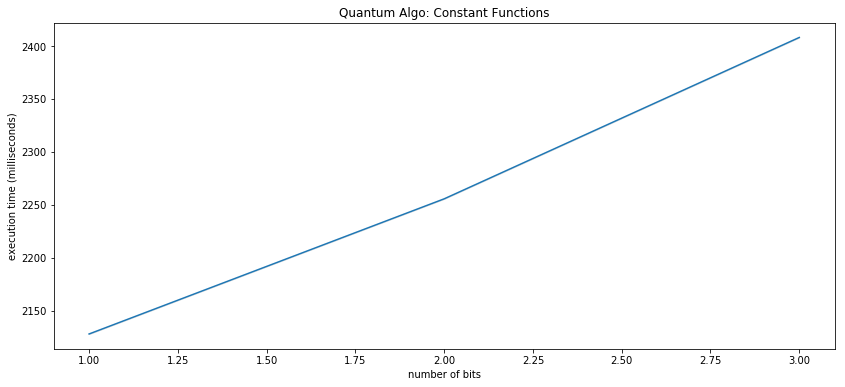

In [216]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", zero_state_ave)

# Plot time it took to run algo
plt.figure(figsize=(14,6))
plt.plot(qs_real_con, q_real_con_t_means * millisec)
plt.fill_between(qs_real_con, (q_real_con_t_means-q_real_con_t_stds) * millisec, 
                 (q_real_con_t_means+q_real_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Quantum Algo: Constant Functions')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

/Users/Razander/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Fit parameters: [0.65689992 0.25597554 1.47127867]


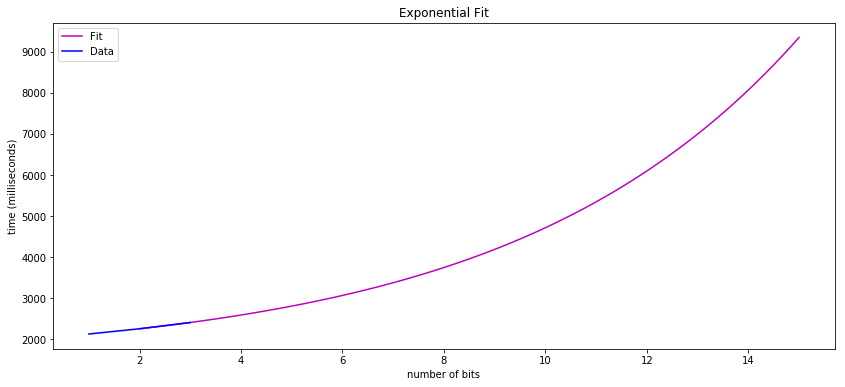

In [217]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

popt, pcov = curve_fit(exp, qs_real_con, q_real_con_t_means)

print("Fit parameters:", popt)
xs = np.linspace(2, 15, 100)
ys = exp(xs, *popt)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys * millisec, '-m')
plt.plot(qs_real_con, q_real_con_t_means * millisec, '-b')
plt.fill_between(qs_real_con, (q_real_con_t_means-q_real_con_t_stds) * millisec, 
                 (q_real_con_t_means+q_real_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Exponential Fit')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Fit','Data'], loc='upper left')
plt.show()

## 16 Qubit Results

In [226]:
backend_bigqc = provider.get_backend('ibmq_16_melbourne')
backend_bigqc.status()

BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.0.6', operational=True, pending_jobs=9, status_msg='active')

In [231]:
reps = 1
qs_realbig_con = np.arange(1, 10)  # last qubit on qc is needed as output qubit
shots_real = 1

# Initialize arrays that will store results
q_realbig_con_t = np.zeros(len(qs_realbig_con) * reps)
q_realbig_con_cs = {}

# Execute quantum circuit and view results
for j in range(reps):
    for i, n in enumerate(qs_realbig_con):
        index = i + j*len(qs_realbig_con)
        q_realbig_con_cs[index], q_realbig_con_t[index] = quantum_algo(uf_const0, int(n), backend_bigqc, shots_real)


## Post Processing

In [232]:
# Compute mean and standard deviation from runs
q_realbig_con_t = q_realbig_con_t.reshape(reps, len(qs_realbig_con))
q_realbig_con_t_means = np.mean(q_realbig_con_t, axis=0)
q_realbig_con_t_stds = np.std(q_realbig_con_t, axis=0)

# Add up number of 0 states from the repeated experiments
label_ave = 0
for key1, val1 in q_realbig_con_cs.items():
    for key2, val2 in val1.items():
        if 0==int(key2):
            label_ave += 1
zero_state_ave = 1 - label_ave / len(qconst_counts)

Average label should be exactly 0: 0.9954545454545455


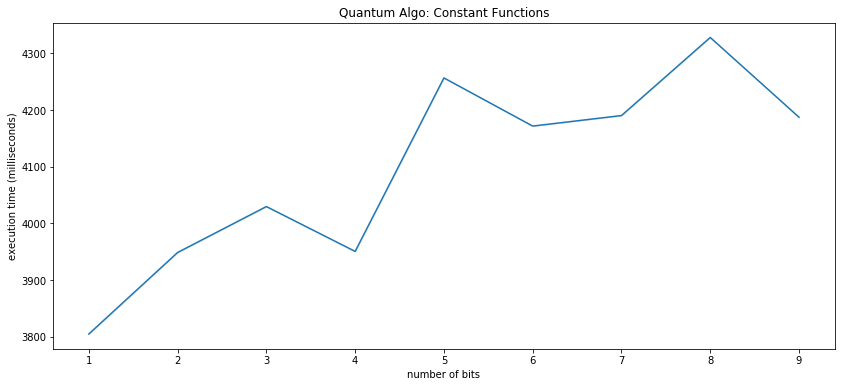

In [233]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", zero_state_ave)

# Plot time it took to run algo
plt.figure(figsize=(14,6))
plt.plot(qs_realbig_con, q_realbig_con_t_means * millisec)
plt.fill_between(qs_realbig_con, (q_realbig_con_t_means-q_realbig_con_t_stds) * millisec, 
                 (q_realbig_con_t_means+q_realbig_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Quantum Algo: Constant Functions')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

In [234]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

popt, pcov = curve_fit(exp, qs_realbig_con, q_realbig_con_t_means)

print("Fit parameters:", popt)
xs = np.linspace(2, 15, 100)
ys = exp(xs, *popt)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys * millisec, '-m')
plt.plot(qs_realbig_con, q_realbig_con_t_means * millisec, '-b')
plt.fill_between(qs_realbig_con, (q_realbig_con_t_means-q_realbig_con_t_stds) * millisec, 
                 (q_realbig_con_t_means+q_realbig_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Exponential Fit')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Fit','Data'], loc='upper left')
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

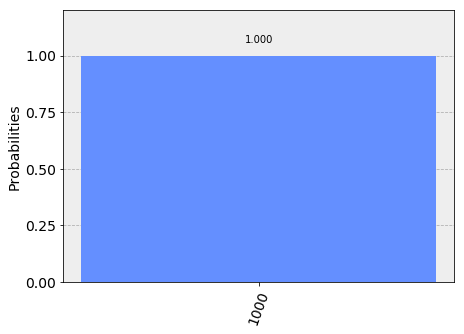

In [16]:
# Execute quantum circuit and view results
start_time = time.time()
result = execute(circuit, backend_sim, shots=sim_shots).result()

counts = result.get_counts(circuit)
visualization.plot_histogram(counts)

### Deutsh-Jozsa real quantum computer

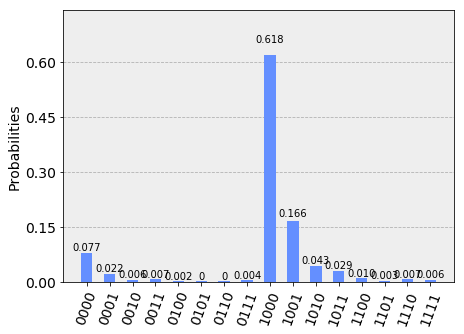

In [17]:
result = execute(circuit, backend_real, shots=max_real_shots).result()
counts = result.get_counts(circuit)
visualization.plot_histogram(counts)

## Quantum Speedup?
Deutsch-Jozsa was the first quantum algorithm that showed exponentially faster computation than a classical computer. For $n$ input bits, a classical computer would need, in a worst case scenario, roughly $2^{n-1}+1$ runs while a quantum computer <strong>needs only 1</strong>! Let's tabulate this to get a little prospective. Let's assume one run for both classical and quantum computers takes 10 nanoseconds (ns).

$$
\begin{array}{c|c|c}
  & \text{classical computation time} & \text{quantum computation time} \\\hline
  n=1 & 2 \text{ ns}& 1 \text{ ns} \\\hline
  n=10 & 513 \text{ ns}& 1  \text{ ns}\\\hline
  n=50 & 6.5 \text{ days}& 1 \text{ ns}\\\hline
  n=90 & 19.6 \gt \text{ billion years}& 1 \text{ ns}\\
\end{array}
$$

For context, $19.6$ <strong>BILLION YEARS</strong> is longer than the universe has been around. THAT's what an exponential speedup means. THAT's why people are so hot on making quantum computers work. (Though to solve other problem's than the Deutsch Problem.)